# imports

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torchvision.transforms as transforms

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from torchviz import make_dot



# Global variables 

In [3]:
# common vars
LABEL_COL = 'label'
CSV_DATA = "images_text.csv"
NUM_CLASSES = 3
LR = 0.001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS=20
BATCH_SIZE = 2024
DF = pd.read_csv(CSV_DATA)


# image vars
IMG_SHAPE = 48
IMAGE_COL = 'local_path'

# text vars
TEXT_COL = "text_emo"
W2V_MODEL = Word2Vec.load("word2vec.model")
EMBEDDING_MATRIX = W2V_MODEL.wv.vectors
SEQUECE_LENGTH = 100
LSTM_HIDDEN_SIZE = 50
VOCAB_SIZE, EMBEDDING_SIZE = W2V_MODEL.wv.vectors.shape
HIDDEN_SIZE = 50


FileNotFoundError: [Errno 2] No such file or directory: 'images_text.csv'

# Image model

In [7]:

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * IMG_SHAPE//16 * IMG_SHAPE//16, 512)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        # self.fc2 = nn.Linear(512, 3)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        # x = self.fc2(x)
        # x = self.softmax(x)
        return x

# Text model

In [8]:
class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        vocab_size, embedding_dim = EMBEDDING_MATRIX.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(EMBEDDING_MATRIX), freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.lstm1 = nn.LSTM(embedding_dim, HIDDEN_SIZE, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(HIDDEN_SIZE * 2, NUM_CLASSES) # *2bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output1, _ = self.lstm1(embedded)
        last_hidden_state = torch.cat((output1[:, -1, :HIDDEN_SIZE], output1[:, 0, HIDDEN_SIZE:]), dim=1) # output1[:, -1, :]
        # logits = self.fc(last_hidden_state)
        return last_hidden_state

# Multimodel attension fusion

In [9]:

# class MultimodalClassifier(nn.Module):
#     def __init__(self, text_model, image_model):
#         super(MultimodalClassifier, self).__init__()
#         self.text_model = text_model
#         self.image_model = image_model
#         self.attention_text = nn.Linear(NUM_CLASSES, NUM_CLASSES)
#         self.attention_image = nn.Linear(NUM_CLASSES, NUM_CLASSES)
#         self.fc = nn.Linear(NUM_CLASSES * 2, NUM_CLASSES)

#     def forward(self, text, image):
#         text_out = self.text_model(text)
#         image_out = self.image_model(image)
        
#         # Calculate attention weights for text and image features
#         attention_text_weights = torch.softmax(self.attention_text(text_out), dim=1)
#         attention_image_weights = torch.softmax(self.attention_image(image_out), dim=1)
        
#         # Apply attention weights to the text and image features
#         attended_text = attention_text_weights * text_out
#         attended_image = attention_image_weights * image_out
        
#         # Concatenate the attended features
#         fusion = torch.cat((attended_text, attended_image), dim=1)
        
#         out = self.fc(fusion)
#         return out
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_model):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.attention_weights = nn.Parameter(torch.Tensor(1, 1, 2))
        self.fc = nn.Linear(HIDDEN_SIZE * 2 + 256, NUM_CLASSES)

    def forward(self, text_input, image_input):
        # Extract text features
        text_features = self.text_model(text_input)  # Shape: [batch_size, HIDDEN_SIZE * 2]

        # Extract image features
        image_features = self.image_model(image_input)  # Shape: [batch_size, 256]

        # Apply attention to text features
        attention_scores = torch.matmul(text_features.unsqueeze(2), self.attention_weights)  # Shape: [batch_size, HIDDEN_SIZE * 2, 1]
        attention_weights = torch.softmax(attention_scores, dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2, 1]
        attended_text_features = (text_features * attention_weights.squeeze(2)).sum(dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2]

        # Concatenate text features and image features
        multimodal_features = torch.cat((attended_text_features, image_features), dim=1)  # Shape: [batch_size, HIDDEN_SIZE * 2 + 256]

        # Classify the multimodal features
        logits = self.fc(multimodal_features)  # Shape: [batch_size, NUM_CLASSES]
        return logits


# early fusion

In [6]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_model):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc = nn.Linear(NUM_CLASSES * 2, NUM_CLASSES)

    def forward(self, text, image):
        text_out = self.text_model(text)
        image_out = self.image_model(image)
        
        # Element-wise multiplication of text and image features
        fusion = text_out * image_out
        
        # Flatten the fusion tensor
        fusion = fusion.view(fusion.size(0), -1)
        
        out = self.fc(fusion)
        return out

# Dataset

In [10]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, word2vec_model):
        self.transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])
        self.dataframe = dataframe
        self.word2vec_model = word2vec_model
        self.preprocessed_sequences = self._preprocess_text()

    def _preprocess_text(self):
        preprocessed_sequences = []
        for idx in range(len(self.dataframe)):
            text = self.dataframe.loc[idx, TEXT_COL]
            tokens = word_tokenize(text)
            sequence_indices = [self.word2vec_model.wv.key_to_index[word] for word in tokens if word in self.word2vec_model.wv]
            padded_sequence = torch.tensor(sequence_indices + [0] * (SEQUECE_LENGTH - len(sequence_indices)))[:SEQUECE_LENGTH]
            preprocessed_sequences.append(padded_sequence)
        return preprocessed_sequences

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.loc[idx, IMAGE_COL]
        label = self.dataframe.loc[idx, LABEL_COL]

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        preprocessed_sequence = self.preprocessed_sequences[idx]

        return preprocessed_sequence, image, label


# functions

In [25]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (text, image, label) in enumerate(train_loader):
        text, image, label = text.to(device), image.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(text, image)
        loss = criterion(output, label)
        acc = accuracy(output, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)


def val(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for batch_idx, (text, image, label) in enumerate(test_loader):
            text, image, label = text.to(device), image.to(device), label.to(device)

            output = model(text, image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(test_loader), running_acc / len(test_loader)


def save_model(model, save_dir, filename):
    torch.save(model.state_dict(), os.path.join(save_dir, filename))


def test(model, predict_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (text, image, label) in enumerate(predict_loader):
            text, image, label = text.to(device), image.to(device), label.to(device)

            output = model(text, image)
            loss = criterion(output, label)
            acc = accuracy(output, label)

            running_loss += loss.item()
            running_acc += acc.item()

            _, preds = torch.max(output, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = running_loss / len(predict_loader)
    avg_acc = running_acc / len(predict_loader)

    return avg_loss, avg_acc, predictions, true_labels

dic = {0: "negative", 1: "neutral", 2: "positive"}

def predict(model, text, image, label=None, eval=True):

    model.eval()

    # text processissng
    max_sequence_length = SEQUECE_LENGTH
    sequence = text
    label = label
    tokens = word_tokenize(sequence)
    sequence_indices = [W2V_MODEL.wv.key_to_index[word] for word in tokens if word in W2V_MODEL.wv]
    padded_sequence = torch.tensor(sequence_indices + [0] * (max_sequence_length - len(sequence_indices)))[:max_sequence_length].unsqueeze(0)

    with torch.no_grad():
        image = image.to(DEVICE)
        text = padded_sequence.to(DEVICE)


        output = model(text, image)
        result = torch.max(output, dim=1).indices[0].cpu().item()
        print("predicted label:", dic[result])
        if label != None:
            print("actual label:", label)
    return output


# Visualize the network

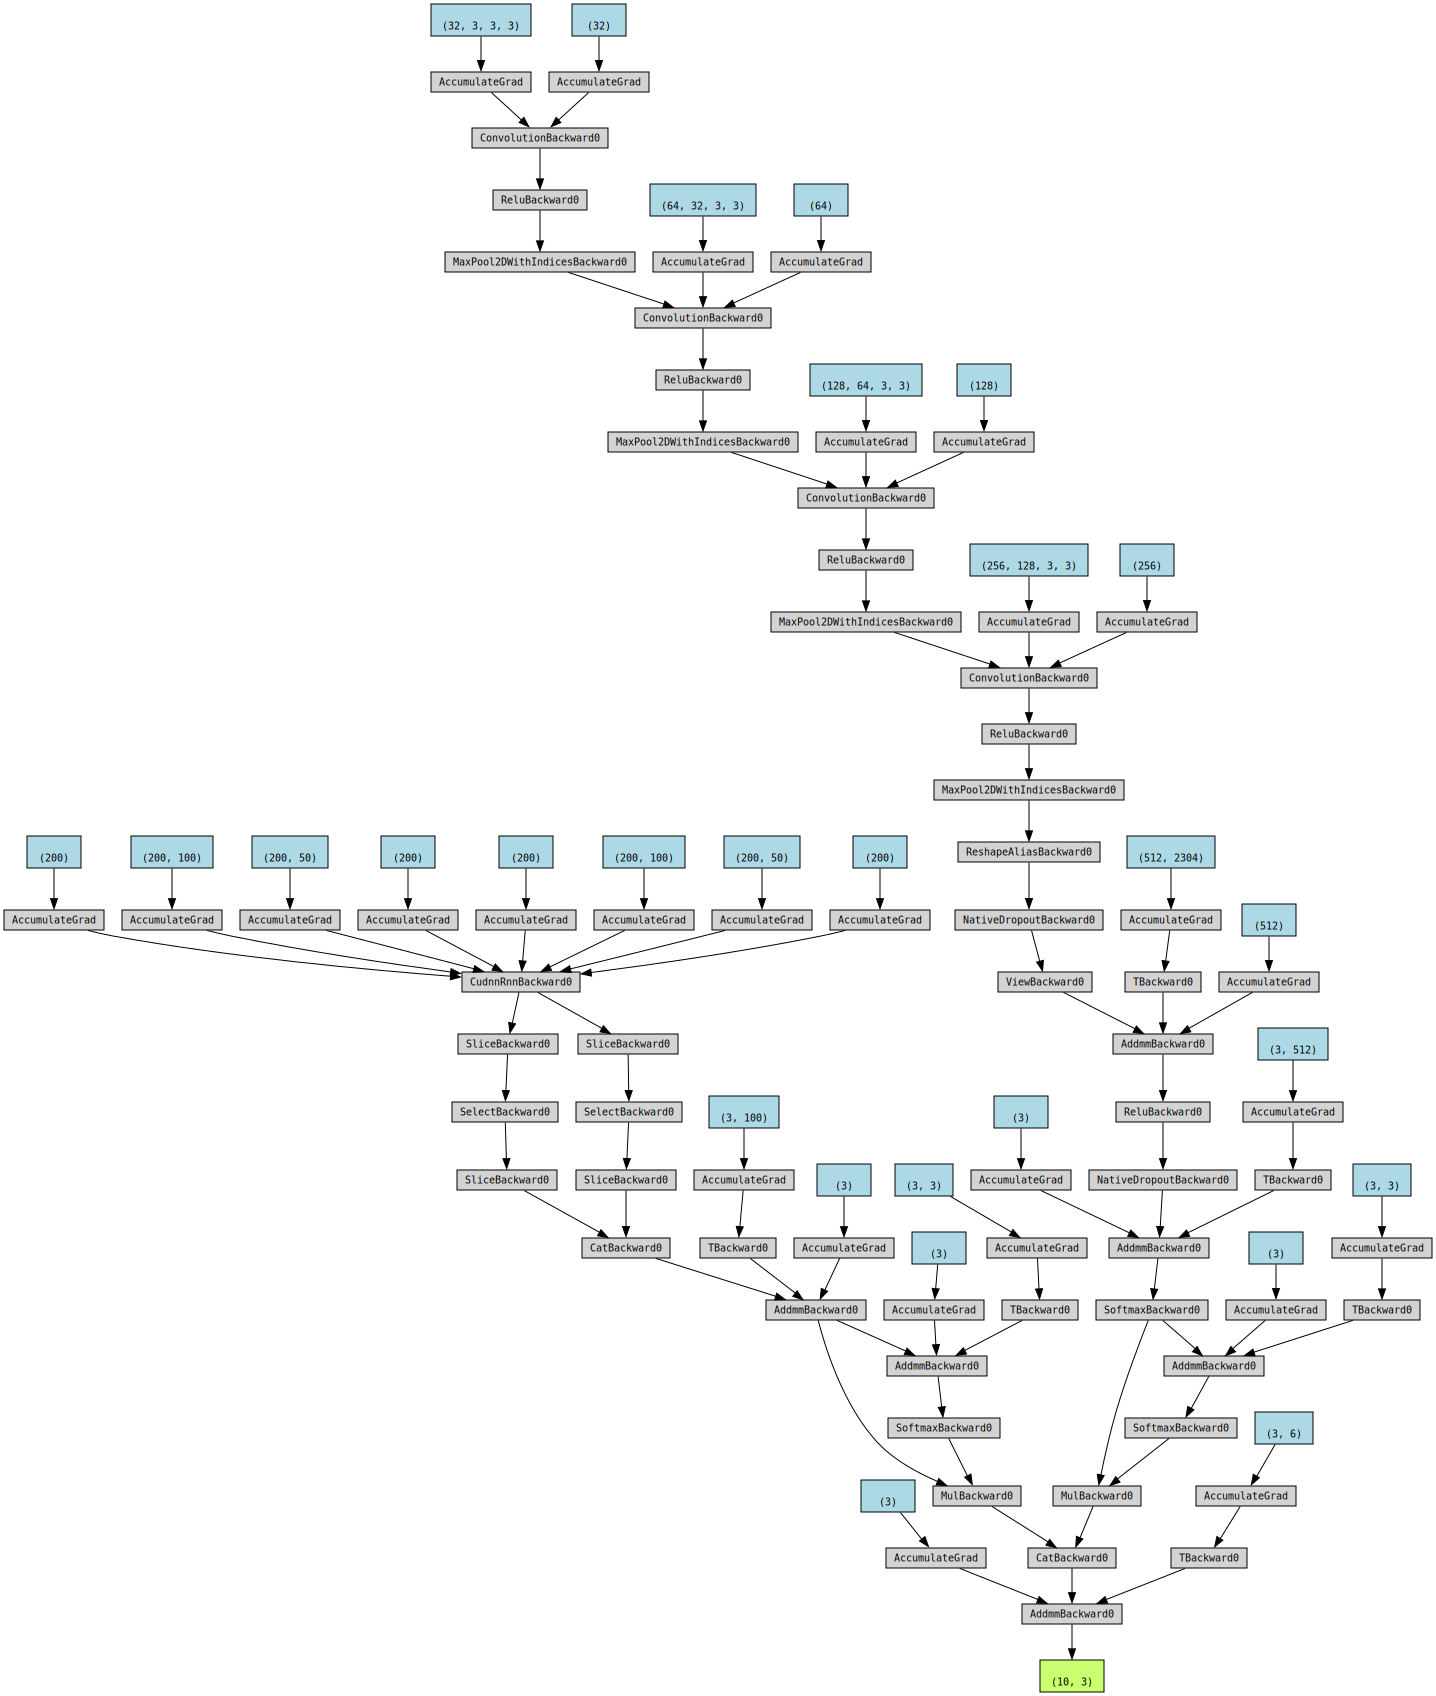

In [24]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


import multiprocessing as mp
data = MultimodalDataset(DF, W2V_MODEL)

indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

BATCH_SIZE = 10

# create data loaders for train and test sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)



text_model = TextClassifier().to(DEVICE)
image_model = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(text_model, image_model).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

preprocessed_sequence, image, label = next(iter(train_loader))
output = model(preprocessed_sequence.to(DEVICE), image.to(DEVICE))

make_dot(output)


# init dataset and model

In [15]:
import multiprocessing as mp
data = MultimodalDataset(DF, W2V_MODEL)

indices = np.arange(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_data = Subset(data, train_indices)
test_data = Subset(data, test_indices)

BATCH_SIZE = 2048

# create data loaders for train and test sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)



text_model = TextClassifier().to(DEVICE)
image_model = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(text_model, image_model).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

MultimodalClassifier(
  (text_model): TextClassifier(
    (embedding): Embedding(13015, 100)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm1): LSTM(100, 50, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=100, out_features=3, bias=True)
  )
  (image_model): ImageClassifier(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (pool4): MaxPool2d(kernel_size=2

# train the model

In [ ]:
%%time
best_val_acc = 0.0
count = 0
val_acc_list = []
train_acc_list = []
val_loss_list = []
train_loss_list = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = val(model, test_loader, criterion, DEVICE)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )
    

    if val_acc > best_val_acc:
        print(f"New best model! Saving...")
        save_model(model, "", "ATTENTION_FUSION_MULTI_MODEL_BEST_MODEL.pt")
        best_val_acc = val_acc
        print(f"Best val acc: {best_val_acc:.4f}")
        count = 0
    else:
        count += 1
        print(f"Count: {count} of epochs have no improvement")
        if count == 5:
            print(f"Early stopping, best val acc: {best_val_acc:.4f}")
            break


# learning rate

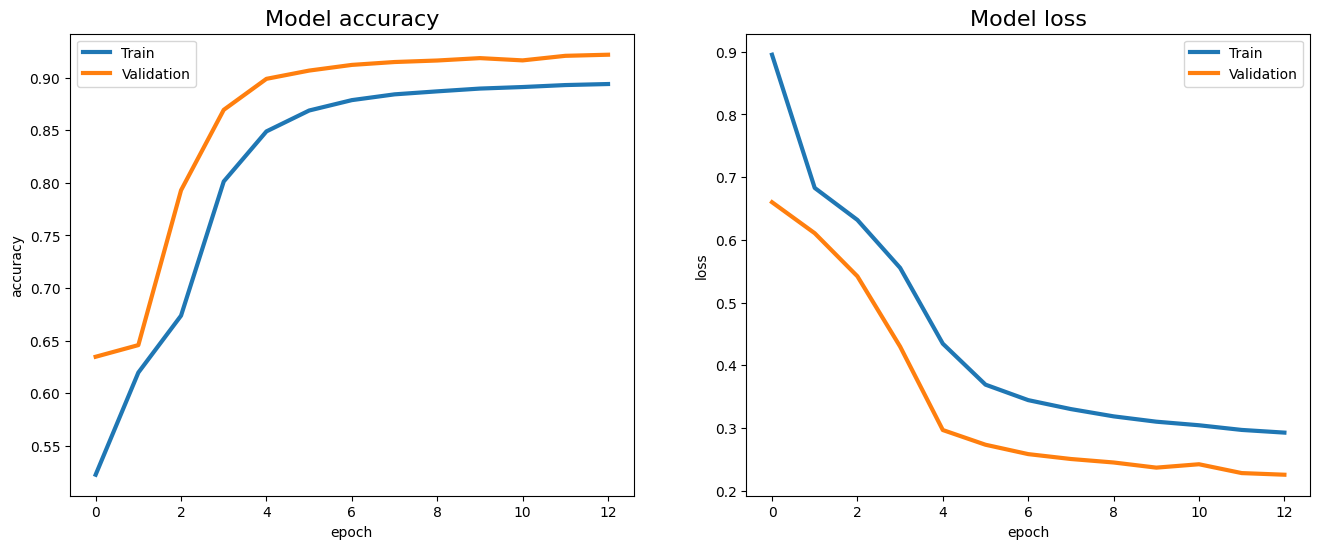

In [25]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
# summarize history for accuracy
axis1.plot(train_acc_list, label='Train', linewidth=3)
axis1.plot(val_acc_list, label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(train_loss_list, label='Train', linewidth=3)
axis2.plot(val_loss_list, label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

# test

In [ ]:

test_loss, test_acc, predictions, true_labels = test(model, test_loader, criterion, DEVICE)

print(f"Test Acc: {test_acc:.4f}")

true_labels = [dic[i] for i in true_labels]
predictions = [dic[i] for i in predictions]

print(classification_report(true_labels,predictions))
cm = confusion_matrix(true_labels,predictions, labels=["negative", "neutral", "positive"])
p = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('The Confusion Martrix of Text model')



# prediction

In [34]:
textmodel = TextClassifier().to(DEVICE)
imagemodel = ImageClassifier().to(DEVICE)

model = MultimodalClassifier(textmodel, imagemodel).to(DEVICE)

model.load_state_dict(torch.load("ATTENTION_FUSION_MULTI_MODEL_BEST_MODEL.pt"))

transform = transforms.Compose([
                        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

image = Image.open("./train_images/t4sa/782694539618349056.jpg").convert('RGB')
image = transform(image).unsqueeze(0)
text = "hhhh"

predict(model, text, image, "positive", False)


predicted label: neutral
actual label: positive


tensor([[ 0.0260,  0.9873, -0.3527]], device='cuda:0')

In [33]:
import cv2
import torch

# Initialize the camera
camera = cv2.VideoCapture(0)

while True:
    # Read the current frame from the camera
    ret, frame = camera.read()

    # Display the frame
    cv2.imshow("Camera", frame)

    # Check if the 'c' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('c'):
        # Save the current frame as an image
        cv2.imwrite("captured_image.jpg", frame)
        print("Image captured!")

        image = Image.open("captured_image.jpg").convert('RGB')
        image = transform(image).unsqueeze(0)
        text = "its fucked"

        predict(model, text, image, "positive", False)



    # Check if the 'q' key is pressed to exit the loopq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
camera.release()
cv2.destroyAllWindows()


Image captured!
predicted label: negative
actual label: positive
Image captured!
predicted label: negative
actual label: positive
Image captured!
predicted label: negative
actual label: positive
Image captured!
predicted label: negative
actual label: positive
Image captured!
predicted label: negative
actual label: positive
